# <center> Wireless sensor networks Localization

This notebook focuses on developing localization techniques in WSN. It begins with preprocessing of channel impulse response data, and trained ensemble model for localization. Then localization with data from different source is studied and a novel framework is proposed and compared with existed method.

In [2]:
# import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import geopy.point as point
from tools import *


## Coordination of maps

In [3]:
def creat_map_configs(corner, x, y):
    '''
    Define boundary of rectangle map given a corner's postion, the length and the width
    returns the range of latitude and longitude
    :corner: coordination of left-bottom corner 
    :     x: latitudinal distance
    :     y: longitudinal distance 
    '''

    east = geodesic(x).destination(corner, 0)
    north = geodesic(y).destination(corner, 90)
    return corner[0], east.latitude, corner[1], north.longitude

In [4]:
#### Generate configs for simulation in MATLAB

# set map of shape 1km-by-1km
x, y = 1, 1

# London map configs
london_corner = [51.5108, -0.0988]
london_config = creat_map_configs(london_corner, x, y)

# Paris map configs
paris_corner = [48.8296, 2.3132] # paris 14e
paris_config = creat_map_configs(paris_corner, x, y)

# Toulouse map configs
toulouse_corner = [43.6048, 1.4393]
toulouse_config = creat_map_configs(toulouse_corner, x, y)

In [6]:
print(f'For london map, the latitude range is {london_config[0:2]}, the longitude range is {london_config[2::]}')

For london map, the latitude range is (51.5108, 51.519788107578044), the longitude range is (-0.0988, -0.08439578091555248)


# Data preparation
- Read data from .mat file

In [7]:
location = 'london_square'
base = f'./dataset/{location}_cell.mat'
meta_data_ld, cir_profile_ld, dist_ld, TX_ld, RX_ld = read_mat(base, location)

- Visulize the distribution of Tx and Rx

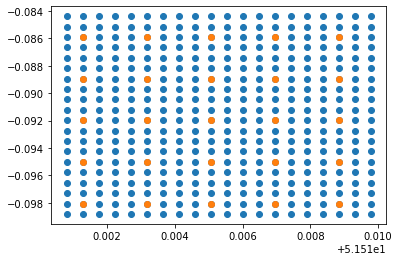

In [8]:
plot_agent(TX_ld)
plot_agent(RX_ld)

- Formatting CIR profiles to a database

In [9]:
max_len = 5 # max number of reflections in a ray trace

# initiate an extractor
ext_ld = Extractor(cir_profile_ld)
# formatting CIR profiles
X_ld = ext_ld.formatting_X(max_len=max_len)

d:\Telecom_2eme_anne\Geolocation_simulation\Polished_code\tools.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mag = - math.floor(math.log(np.mean(self.delay_set), 10))
d:\Telecom_2eme_anne\Geolocation_simulation\Polished_code\tools.py:176: ComplexWarning: Casting complex values to real discards the imaginary part
  cir_t.append(np.array(cir_shaped, dtype='float'))


C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


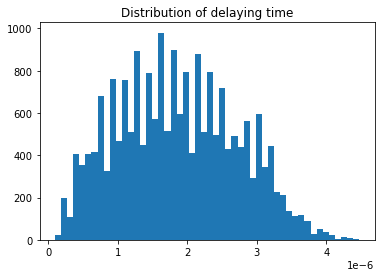

In [10]:
_ = plt.hist(ext_ld.delay_set, bins=50)
_ = plt.title('Distribution of delaying time')

Text(0.5, 0, '#-of-raytraces')

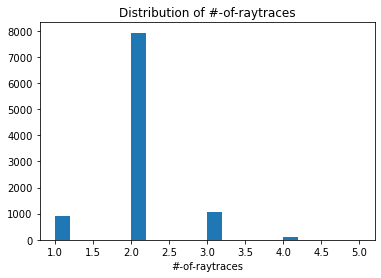

In [11]:
_ = plt.hist(ext_ld.ray_len, bins=20)
plt.title('Distribution of #-of-raytraces')
plt.xlabel('#-of-raytraces')

# Prediction using ensemble method

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.pipeline import Pipeline
import lightgbm as lgb

In [11]:
# Training preparation

x_train, x_test, y_train, y_test = train_test_split(X_ld, TX_ld, train_size=.75)

In [12]:
rf_grid = {
    'rf__max_depth': [100, 200, 500, 1000, 1500, 2000]
}

lgb_grid = {
    'xgb__estimator__n_estimators': [100, 200, 500, 1000],
    'xgb__estimator__max_depth': [100, 200, 500, 1000, 2000]
}

xgb_grid = {
    'xgb__estimator__n_estimators': [100, 200, 500, 1000],
    'xgb__estimator__max_depth': [100, 200, 500, 1000, 2000]
}

ada_grid = {
    'ada__estimator__n_estimators': [50, 100, 200]
}

xgb_pipe = GridSearchCV(
                Pipeline([('scale', StandardScaler()), \
                    ('xgb', MultiOutputRegressor(xgb.XGBRegressor(eta=0.1, 
                                                    subsample=1, 
                                                    colsample_bytree=1, 
                                                    reg_lambda=0))
                                                    )]),
                xgb_grid)

lgb_pipe = GridSearchCV(
                Pipeline([('scale', StandardScaler()), \
                    ('lgb', MultiOutputRegressor(lgb.LGBMRegressor(eta=0.1, 
                                                                    subsample=1, 
                                                                    colsample_bytree=1, 
                                                                    reg_lambda=0)))]),
                lgb_grid)

rf_pipe = GridSearchCV(
                Pipeline([('scale', StandardScaler()), ('rf', RF())]), 
                rf_grid)

ada_pipe = GridSearchCV(
                Pipeline([('scale', StandardScaler()), \
                ('ada', MultiOutputRegressor(ABR(n_estimators=100)))]), 
                ada_grid)

In [64]:
pipes = [xgb_pipe, lgb_pipe, rf_pipe, ada_pipe]
model_ls = ['XGB', 'LGBM', 'RF', 'ADA']

pipes_ld = PipesFitting(X_ld, TX_ld, RX_ld)
pipes_ld.add_pipes(pipes, model_ls)
pipes_ld.fit()

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


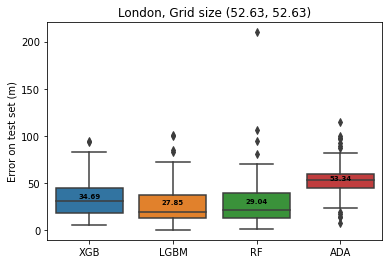

In [65]:
v_ld = VisualizeResult(pipes_ld, location='London')
v_ld.boxplot_pipes()


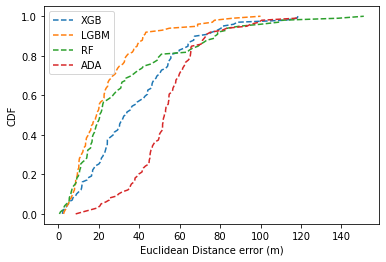

In [15]:
v_ld.cdf_plot()

## Position estimation on data from new maps

In [16]:
# dataset directory

paris_20 = 'paris_square_20'
toulouse_20 = 'toulouse_square_20'

base_pr = f'./dataset/{paris_20}_cell.mat'
base_tl = f'./dataset/{toulouse_20}_cell.mat'

In [365]:
# read .mat file
## read info: meta data, cir profile, distance between every tx and every rx, location of tx, location of rx

meta_pr, cirs_pr, dist_pr, TX_pr, RX_pr = read_mat(base_pr, paris_20)
meta_toul, cirs_toul, dist_toul, TX_toul, RX_toul = read_mat(base_tl, toulouse_20)

In [20]:
# formatting data from other cities

ext_pr = Extractor(cirs_pr, RX_pr)
ext_tl = Extractor(cirs_toul, RX_toul)

X_pr = ext_pr.formatting_X(max_len)
X_tl = ext_tl.formatting_X(max_len)

In [26]:
# calculating the offest between cities

pr_shift = TX_pr.mean(axis=0) - TX_ld.mean(axis=0)
tl_shift = TX_toul.mean(axis=0) - TX_ld.mean(axis=0)

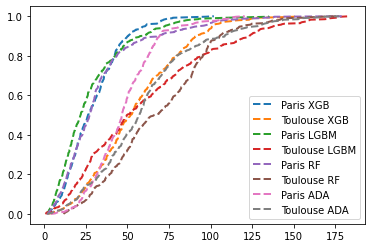

In [66]:
pr_errors = [] # list storing distance estimatino errors for every ensemble method
tl_errors = []

for model, pipe in zip(model_ls, pipes_ld.model_all):
    pr_pred = pipe.predict(X_pr) + pr_shift
    tl_pred = pipe.predict(X_tl) + tl_shift

    pr_error = dist_from_geo(pr_pred, TX_pr)
    tl_error = dist_from_geo(tl_pred, TX_toul)

    # plt.figure()
    cdf_plot(pr_error, label=f'Paris {model}')
    cdf_plot(tl_error, label=f'Toulouse {model}')

    pr_errors.append(pr_error)
    tl_errors.append(tl_error)
plt.legend()

# Prediction on data from other sources

## Build model for distance prediction

In [29]:
from scipy.optimize import minimize, Bounds

In [48]:
def point_searching(RX, dist_pred):
    """find point x through distance and rx coordinates"""

    def func(x, coords, dists):
        '''
        Objective function, evaluates the difference between the distance of point with all RX and distances estimated
        '''
        d = np.array([geodesic(x, coord).m for coord in coords])

        return np.linalg.norm([d-dists])**2

    x_pred = []

    bounds = Bounds([0, -90], [90, 90])

    for p in dist_pred:
        res = minimize(
        func,
        RX[0],
        args=(RX, p),
        method='L-BFGS-B',
        options={
            'ftol':1e-5,         # Tolerance
            'maxiter': 1e+7      # Maximum iterations
        },
        bounds=bounds
    )   

        x_pred.append(res.x)

    return np.array(x_pred)

In [67]:
# Train a model for distance prediction

model_dist = lgb_pipe

model_dist.fit(X_ld, dist_ld)

pr_dist_pred = model_dist.predict(X_pr)
tl_dist_pred = model_dist.predict(X_tl)

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


In [68]:
# Find points by optimization

loc_new_pr = point_searching(RX_pr, pr_dist_pred)
loc_new_tl = point_searching(RX_toul, tl_dist_pred)

In [56]:
# error measurement
e_new_pr = dist_from_geo(loc_new_pr, TX_pr)
e_new_tl = dist_from_geo(loc_new_tl, TX_toul)

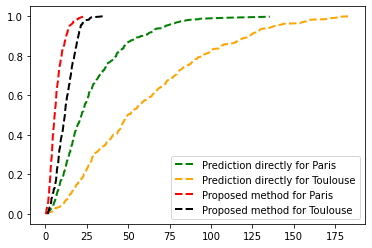

In [74]:
cdf_plot(pr_errors[1], label='Prediction directly for Paris', c='g')
cdf_plot(tl_errors[1], label='Prediction directly for Toulouse', c='orange')
cdf_plot(e_new_pr, label='Proposed method for Paris', c='r')
cdf_plot(e_new_tl, label='Proposed method for Toulouse', c='k')
plt.legend()

## Impact of supplemented data

In [75]:
percentages = [0, .1, .2, .3, .5]

In [116]:
def impact_supplement(source, 
                    target, 
                    source_dist,
                    target_dist,
                    source_label, 
                    target_label,
                    target_RX, 
                    percentages, 
                    model,
                    supply_weight=1):
    '''
    Evaluate the impact of supplemented source data in different percentages,
    supplemented data can be assigned to different weights.
    returns the errors under different percent of supplemented data
    '''

    dist_errors = [] # errors for each percentage of supplemented data
    for p in percentages:
        if p == 0:
            X_mixed = source
            Y_mixed = source_dist
            target_test = target
            target_dist_train = None
            target_tx_test = target_label

            sample_weight = np.ones(len(X_mixed)) # weight for source and target training data

        else:
            target_train, target_test, target_dist_train, _, _, target_tx_test = train_test_split(target, target_dist, target_label, train_size=p)

            X_mixed = np.concatenate([source, target_train])
            Y_mixed = np.concatenate([source_dist, target_dist_train])

            sample_weight = np.ones(len(X_mixed))
            sample_weight[-len(target_dist_train):] *= supply_weight # weights for supplemented data

        model.fit(X_mixed, Y_mixed, model__sample_weight=sample_weight)
        target_dist_pred = model.predict(target_test)
        loc_target = point_searching(target_RX, target_dist_pred)

        dist_errors.append(dist_from_geo(loc_target, target_tx_test))
    
    return dist_errors


In [117]:
lgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('model', MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])

In [114]:
# model trained with London data, and supplemented paris data

errors_pr_supplemented = impact_supplement(X_ld,
                                        X_pr,
                                        dist_ld,
                                        dist_pr,
                                        TX_ld,
                                        TX_pr,
                                        RX_pr,
                                        percentages,
                                        lgb_pipe)

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
(400, 25) (25, 2) (400, 25)
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
(360, 25) (25, 2) (440, 25)
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
(320, 25) (25, 2) (480, 25)
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
(280, 25) (25, 2) (520, 25)
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
(200, 25) (25, 2) (600, 25)


Text(0.5, 0, 'Error (m)')

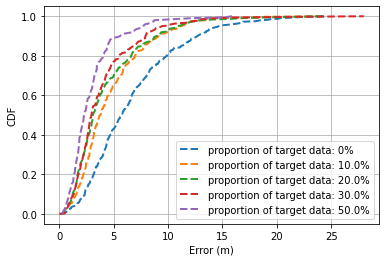

In [120]:
for d_e, p in zip(errors_pr_supplemented, percentages):
    cdf_plot(d_e, label=f'proportion of target data: {p*100}%')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')

In [119]:
# model trained with London data, and supplemented Toulouse data

errors_tl_supplemented = impact_supplement(X_ld,
                                        X_tl,
                                        dist_ld,
                                        dist_toul,
                                        TX_ld,
                                        TX_toul,
                                        RX_toul,
                                        percentages,
                                        lgb_pipe)

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


Text(0.5, 0, 'Error (m)')

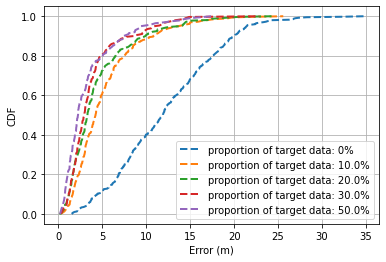

In [121]:
for d_e, p in zip(errors_tl_supplemented, percentages):
    cdf_plot(d_e, label=f'proportion of target data: {p*100}%')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')

## Assigning different weights to supplemented data

In [123]:
# Trained with London data and supplemented Paris data
# weight ratio London data: Paris data = 1:10

errors_pr_supplemented_weight = impact_supplement(X_ld,
                                        X_pr,
                                        dist_ld,
                                        dist_pr,
                                        TX_ld,
                                        TX_pr,
                                        RX_pr,
                                        percentages,
                                        lgb_pipe,
                                        supply_weight=10)

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


Text(0.5, 1.0, 'Test in Paris')

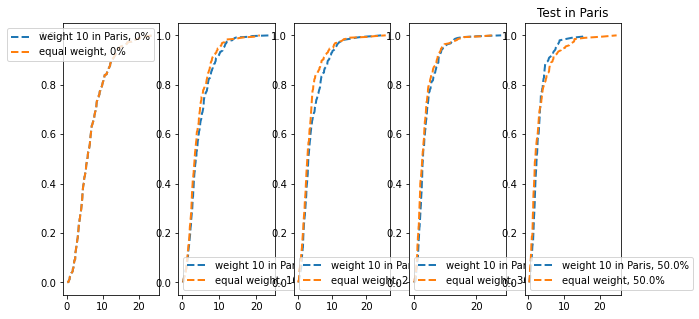

In [177]:
fig, axs = plt.subplots(1, len(percentages), figsize=(10, 5))
axs = axs.flatten()

for i in range(len(percentages)):
    cdf_plot(errors_pr_supplemented[i], ax=axs[i], label=f'weight 10 in Paris, {percentages[i] * 100}%')
    cdf_plot(errors_pr_supplemented_weight[i], ax=axs[i], label=f'equal weight, {percentages[i] *100}%')

    _ = axs[i].legend()
plt.title('Test in Paris')

In [136]:
# Trained with London data and supplemented Toulouse data
# weight ratio London data: Toulouse data = 1:10

errors_tl_supplemented_weight = impact_supplement(X_ld,
                                        X_tl,
                                        dist_ld,
                                        dist_toul,
                                        TX_ld,
                                        TX_toul,
                                        RX_toul,
                                        percentages,
                                        lgb_pipe,
                                        supply_weight=10)

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


Text(0.5, 1.0, 'Test on Toulouse')

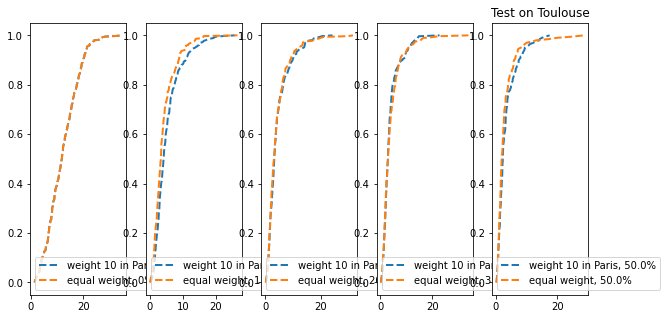

In [176]:
fig, axs = plt.subplots(1, len(percentages), figsize=(10, 5))
axs = axs.flatten()

for i in range(len(percentages)):
    cdf_plot(errors_tl_supplemented[i], ax=axs[i], label=f'weight 10 in Paris, {percentages[i] * 100}%')
    cdf_plot(errors_tl_supplemented_weight[i], ax=axs[i], label=f'equal weight, {percentages[i] *100}%')

    _ = axs[i].legend()

plt.title('Test on Toulouse')

# Range-based method
Norrdine, Abdelmoumen. (2015). An Algebraic Solution to the Multilateration Problem. 10.13140/RG.2.1.1681.3602. 

In [465]:
def toa_ex(data):
    '''
    Extract distance feature based on time-of-arrival from cir measurements
    returns distance between each tx and rx
    '''
    toa = []
    for d in data:
        toa.append([abs(di[0,0] * 3e8) for di in d])

    return np.array(toa)

def geo2cart(RX):
    '''
    Transfer geolocation to cartesian coordinates
    take 1st rx as origin, other coordinations are positions relative to the origin
    '''
    cart_grids = [np.array([0, 0])]

    for i in range(1, len(RX)):
        lat_tmp = geodesic([RX[i][0], RX[0][1]], RX[0]).m
        lon_tmp = geodesic([RX[0][0], RX[i][1]], RX[0]).m

        cart_grids.append(np.array([lat_tmp, lon_tmp]))

    return np.array(cart_grids)

def cart2geo(cart, corner):
    ''''
    Transfer cartesian coordination to geolocation 
    '''
    lat = geodesic(cart[0] / 1000).destination(corner, 0).latitude
    lon = geodesic(cart[1] / 1000).destination(corner, 90).longitude
    return np.array([lat, lon])

def toa_based_multilateration(cir, rx):
    '''Time-of-Arrival based mulilateration localization'''

    dist_toa = toa_ex(cir)
    cart_rx = geo2cart(rx)

    A = np.concatenate([np.ones(shape=(len(cart_rx), 1)), -2 * cart_rx], axis=1)
    b_const = cart_rx[:, 0]**2 - cart_rx[:, 1]**2
    L = np.linalg.inv(A.T @ A) @ A.T 

    loc_estim = []
    test = []
    for dt in dist_toa:
        b = dt**2 - b_const
        sol = L @ b # Sol = [x^2+y^2, x, y]
        loc = cart2geo(sol[1::], rx[0])
        loc_estim.append(loc)
        test.append([sol[1], sol[2]])

    return np.array(loc_estim), test


In [466]:
# position estimation based on ToA for different cities

loc_toa_pr, test1 = toa_based_multilateration(cirs_pr, RX_pr)
loc_toa_tl, test2 = toa_based_multilateration(cirs_toul, RX_toul)

In [467]:
# Error measurements
e_toa_pr = dist_from_geo(loc_toa_pr, TX_pr)
e_toa_tl = dist_from_geo(loc_toa_tl, TX_toul)

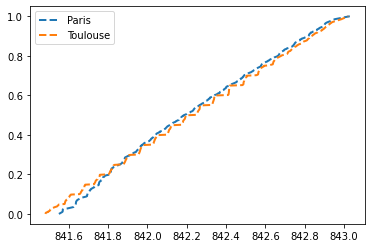

In [470]:
cdf_plot(e_toa_pr, label='Paris')
cdf_plot(e_toa_tl, label='Toulouse')
plt.legend()